<a href="https://colab.research.google.com/github/Palaeoprot/IPA/blob/main/Skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title #Import Libraries and Setup
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import math
import json
import gspread
from datetime import datetime
import random
from scipy.optimize import differential_evolution, curve_fit, minimize
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import logging
from typing import List, Dict, Tuple
import configparser
import argparse

Mounted at /content/drive


Data loaded successfully from Google Sheet

Cleaned data:
   Pre-heat bleach time (h)  temp (°C)  pH sample  time (h)  [Asx]  [Glx]  \
0                        72         80   7    FAA       0.0   36.0   21.0   
1                        72         80   7    FAA       0.0   42.0   25.0   
2                        72         80   7    FAA       0.0   52.0   31.0   
4                        72        110   7    FAA       0.0  116.0   85.0   
5                        72        110   7    FAA       0.0  260.0   55.0   

   [Ser]  [Ala]  [Val]  [Phe]  [Ile]  Asx D/L  Glx D/L  Ser D/L  Ala D/L  \
0  190.0  111.0   19.0   29.0   18.0     0.21     0.00     0.11     0.07   
1  157.0   97.0   15.0   29.0   16.0     0.00     0.00     0.13     0.00   
2  151.0  102.0   16.0   27.0   16.0     0.10     0.00     0.11     0.05   
4  115.0   62.0   12.0   22.0   18.0     0.08     0.09     0.24     0.09   
5   78.0   45.0    7.0   18.0   14.0     0.02     0.06     0.22     0.11   

   Val D/L  Phe D/L  I

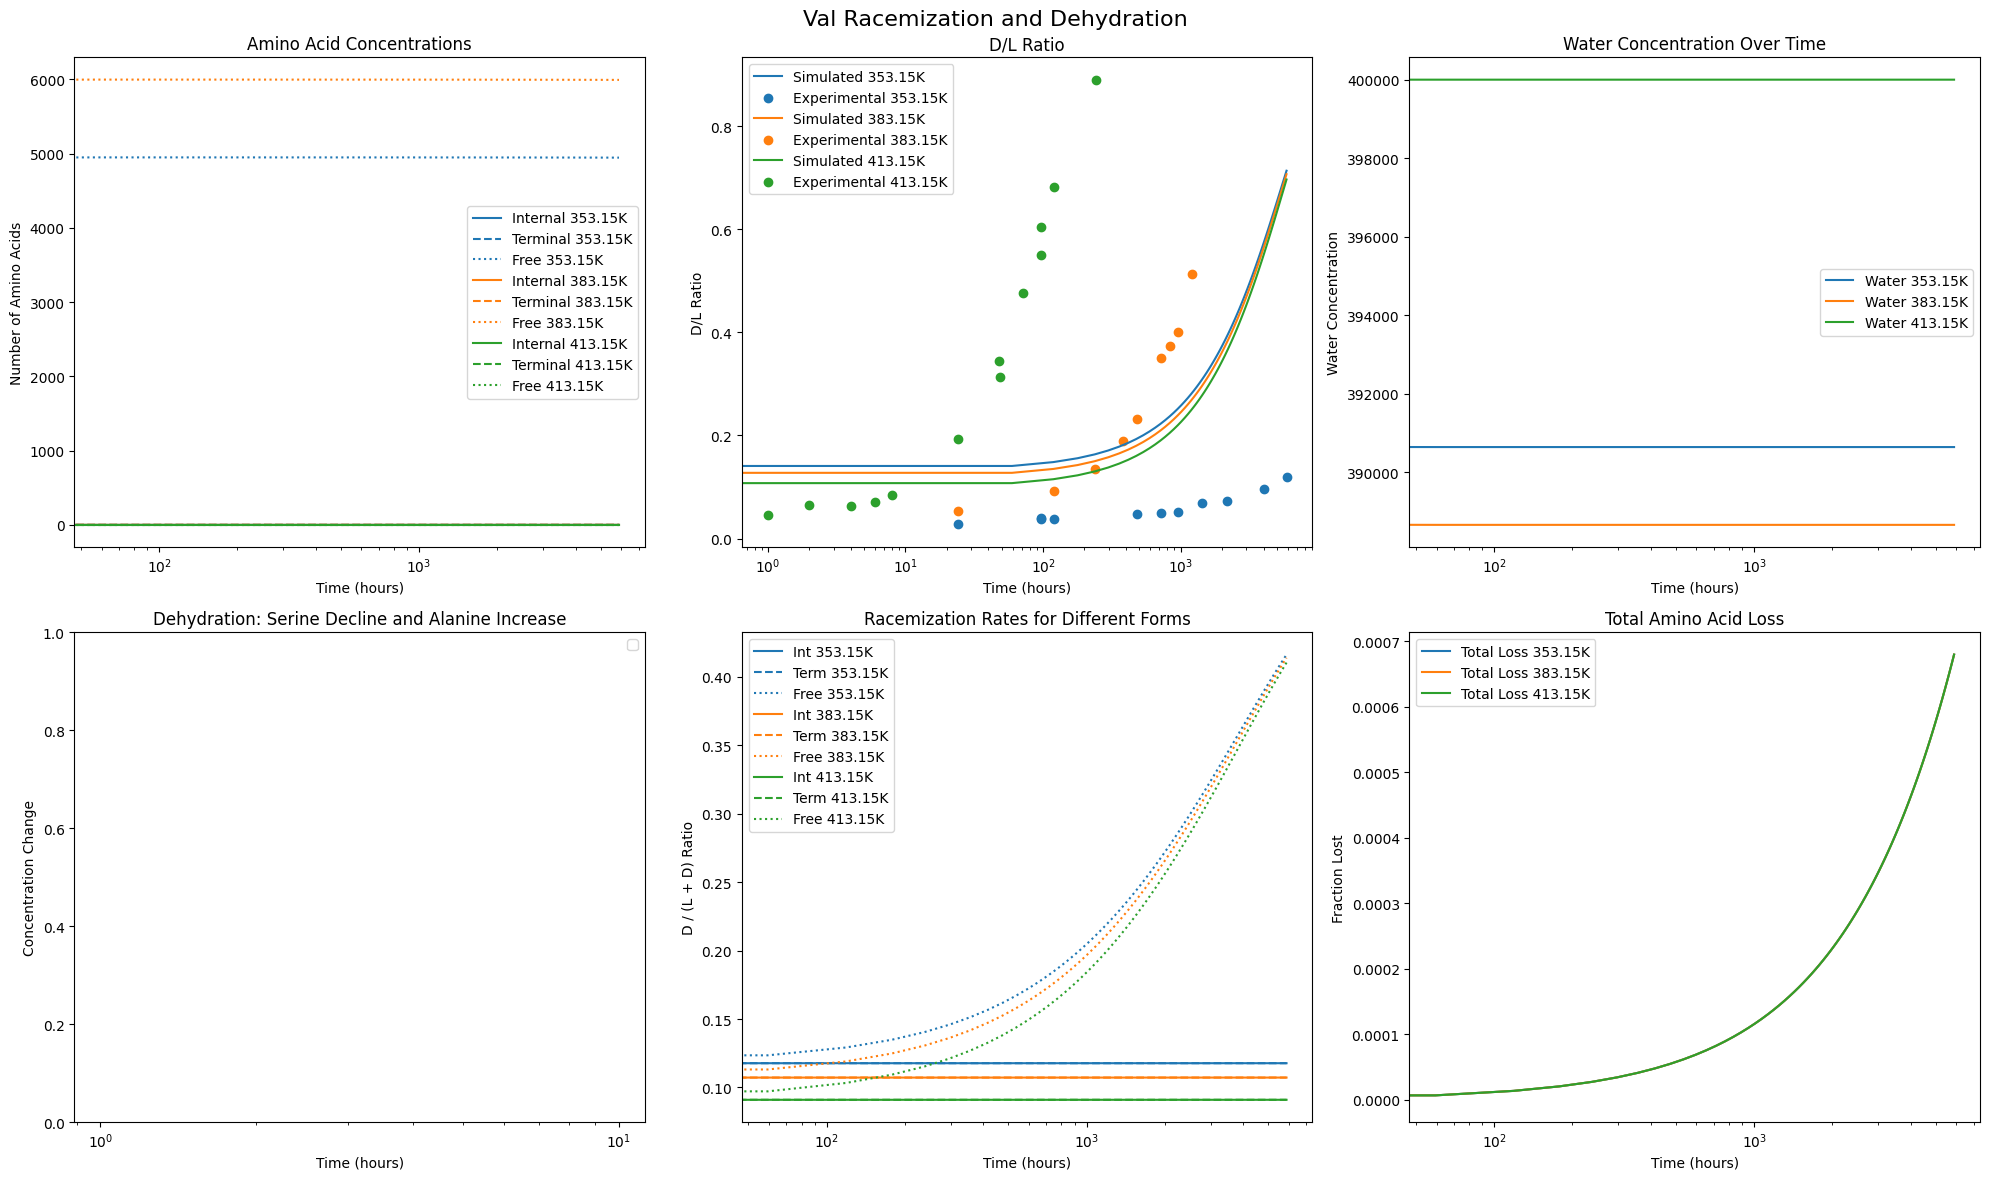

In [2]:
#@title #ModulAAR
class ModulAAR:
    def __init__(self, config):
        self.config = config
        self.data = None
        self.processed_data = None
        self.temperatures = []
        self.amino_acids = []
        self.activation_energies = {...}  # Your activation energies dictionary
        self.R = 8.314  # Gas constant in J/(mol·K)
        self.rate_constants = {}
        self.water_generation = {}
        self.color_dict = self._load_color_dictionary()
        self.amino_acid_colors = self._setup_amino_acid_colors()

    def _load_color_dictionary(self):
        color_dict_path = '/content/drive/MyDrive/Colab_Notebooks/Dictionaries/Colours/colors.json'
        with open(color_dict_path, 'r') as file:
            return json.load(file)

    def _setup_amino_acid_colors(self):
        amino_acid_colors = self.color_dict["amino_acids_colors"]
        one_to_three_letter = {'A': 'Ala', 'R': 'Arg', 'N': 'Asn', 'D': 'Asp', 'C': 'Cys', 'E': 'Glu', 'Q': 'Gln',
                               'G': 'Gly', 'H': 'His', 'I': 'Ile', 'L': 'Leu', 'K': 'Lys', 'M': 'Met', 'F': 'Phe',
                               'P': 'Pro', 'S': 'Ser', 'T': 'Thr', 'W': 'Trp', 'Y': 'Tyr', 'V': 'Val'}

        amino_acid_colors_three_letter = {one_to_three_letter[k]: v for k, v in amino_acid_colors.items() if k in one_to_three_letter}
        three_letter_to_Conc = {k: f'[{k}]' for k in amino_acid_colors_three_letter.keys()}
        amino_acid_colors_conc = {three_letter_to_Conc[k]: v for k, v in amino_acid_colors_three_letter.items() if k in three_letter_to_Conc}

        return amino_acid_colors_conc

    def load_data(self, source, is_gsheet=False):
        try:
            if is_gsheet:
                sheet_id = source['sheet_id']
                gid = source['gid']
                export_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv&gid={gid}"
                self.data = pd.read_csv(export_url)
                print(f"Data loaded successfully from Google Sheet")
            else:
                self.data = pd.read_csv(source)
                print(f"Data loaded successfully from {source}")
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            self.data = None
        return self.data

    def process_data(self, df=None):
        if df is None:
            df = self.data
        if df is None:
            print("No data available for processing.")
            return None

        # Rename 'time (h)' to 'time' for consistency
        df = df.rename(columns={'time (h)': 'time'})

        # Convert temperature to Kelvin if it's in Celsius
        if 'temp (°C)' in df.columns:
            df['temp (K)'] = df['temp (°C)'] + 273.15

        # Extract unique temperatures and amino acids
        self.temperatures = sorted(df['temp (K)'].unique())
        self.amino_acids = ['Asx', 'Glx', 'Ser', 'Ala', 'Val', 'Phe', 'Ile']

        # Create separate DataFrames for FAA and THAA
        faa_df = df[df['sample'] == 'FAA']
        thaa_df = df[df['sample'] == 'THAA']

        # Combine FAA and THAA data
        processed_data = pd.DataFrame()
        for aa in self.amino_acids:
            processed_data[f'{aa}_Conc_FAA'] = faa_df.groupby(['temp (K)', 'time'])[f'[{aa}]'].mean()
            processed_data[f'{aa}_Conc_THAA'] = thaa_df.groupby(['temp (K)', 'time'])[f'[{aa}]'].mean()
            processed_data[f'{aa}_D/L_FAA'] = faa_df.groupby(['temp (K)', 'time'])[f'{aa} D/L'].mean()
            processed_data[f'{aa}_D/L_THAA'] = thaa_df.groupby(['temp (K)', 'time'])[f'{aa} D/L'].mean()

        processed_data = processed_data.reset_index()
        return processed_data

    def clean_data(self):
        if self.data is None:
            print("No data available to clean.")
            return None

        # Strip whitespace from all columns and replace non-numeric characters in relevant columns
        self.data = self.data.applymap(lambda x: x.strip() if isinstance(x, str) else x)

        # Columns that should contain numeric values
        numeric_columns = [
            '[Asx]', '[Glx]', '[Ser]', '[Ala]', '[Val]', '[Phe]', '[Ile]',
            'Asx D/L', 'Glx D/L', 'Ser D/L', 'Ala D/L', 'Val D/L', 'Phe D/L', 'Ile D/L'
        ]

        for col in numeric_columns:
            self.data[col] = self.data[col].astype(str).str.replace(r'[^\d.-]', '', regex=True)
            self.data[col] = pd.to_numeric(self.data[col], errors='coerce')

        # Drop rows with NaN values in numeric columns
        self.data = self.data.dropna(subset=numeric_columns)

        return self.data

    def optimize_parameters(self, amino_acid, time_points):
        def objective(params):
            self.config['rate_params'] = {
                'k_hydrolysis': params[0],
                'k_racemization_int': params[1],
                'k_racemization_term': params[2],
                'k_racemization_free': params[3],
                'k_loss': params[4],
                'k_water_generation': params[5]
            }
            simulated = self.simulate(amino_acid, time_points)
            experimental = self.processed_data[self.processed_data['time'].isin(time_points)]

            total_error = 0
            for temp in simulated.keys():
                sim_data = simulated[temp]
                exp_data = experimental[experimental['temp (K)'] == temp]

                # Interpolate simulated data to match experimental time points
                interp_func = interp1d(sim_data['time'], sim_data['DL_ratio'], bounds_error=False, fill_value="extrapolate")
                sim_dl_ratio = interp_func(exp_data['time'])

                error = np.sum((sim_dl_ratio - exp_data[f'{amino_acid}_D/L_THAA'])**2)
                total_error += error

            return total_error

        initial_guess = [1e-5, 1e-6, 1e-5, 1e-4, 1e-7, 1e-8]
        bounds = [(0, 1e-2)] * 6  # Adjust bounds as needed

        result = minimize(objective, initial_guess, method='L-BFGS-B', bounds=bounds)

        if result.success:
            self.config['rate_params'] = {
                'k_hydrolysis': result.x[0],
                'k_racemization_int': result.x[1],
                'k_racemization_term': result.x[2],
                'k_racemization_free': result.x[3],
                'k_loss': result.x[4],
                'k_water_generation': result.x[5]
            }
            print(f"Optimized parameters: {self.config['rate_params']}")
        else:
            print("Parameter optimization failed")

    def simulate(self, amino_acid, time_points):
        simulated_results = {}
        for temp in self.temperatures:
            initial_conditions = self._get_initial_conditions(amino_acid, temp)
            params = self._get_rate_parameters(amino_acid, temp)

            solution = odeint(self._ode_system, initial_conditions, time_points, args=(params,))

            results = pd.DataFrame({
                'time': time_points,
                'L_int': solution[:, 0],
                'D_int': solution[:, 1],
                'L_term': solution[:, 2],
                'D_term': solution[:, 3],
                'L_free': solution[:, 4],
                'D_free': solution[:, 5],
                'water': solution[:, 6]
            })

            results['DL_ratio'] = (results['D_int'] + results['D_term'] + results['D_free']) / \
                                  (results['L_int'] + results['L_term'] + results['L_free'])

            simulated_results[temp] = results

        return simulated_results

    def _ode_system(self, y, t, params):
        L_int, D_int, L_term, D_term, L_free, D_free, water = y
        k_hydrolysis, k_racemization_int, k_racemization_term, k_racemization_free, k_loss, k_water_generation = params

        dL_int = -k_hydrolysis * L_int * water - k_racemization_int * L_int + k_racemization_int * D_int
        dD_int = -k_hydrolysis * D_int * water + k_racemization_int * L_int - k_racemization_int * D_int
        dL_term = k_hydrolysis * L_int * water - k_hydrolysis * L_term * water - k_racemization_term * L_term + k_racemization_term * D_term
        dD_term = k_hydrolysis * D_int * water - k_hydrolysis * D_term * water + k_racemization_term * L_term - k_racemization_term * D_term
        dL_free = k_hydrolysis * L_term * water - k_loss * L_free - k_racemization_free * L_free + k_racemization_free * D_free
        dD_free = k_hydrolysis * D_term * water - k_loss * D_free + k_racemization_free * L_free - k_racemization_free * D_free
        dwater = -k_hydrolysis * (L_int + D_int) * water - k_hydrolysis * (L_term + D_term) * water + k_water_generation

        return [dL_int, dD_int, dL_term, dD_term, dL_free, dD_free, dwater]

    def _get_initial_conditions(self, amino_acid, temperature):
            initial_data = self.processed_data[(self.processed_data['temp (K)'] == temperature) & (self.processed_data['time'] == self.processed_data['time'].min())]

            # Check if initial_data is empty and handle the case
            if initial_data.empty:
                print(f"Warning: No initial data found for temperature {temperature}K. Using default initial conditions.")
                total_aa = 1.0 # Replace with a sensible default value
                initial_dl_ratio = 0.1 # Replace with a sensible default value
            else:
                total_aa = initial_data[f'{amino_acid}_Conc_THAA'].iloc[0]
                initial_dl_ratio = initial_data[f'{amino_acid}_D/L_THAA'].iloc[0]

            L_initial = total_aa / (1 + initial_dl_ratio)
            D_initial = total_aa - L_initial

            return [
                L_initial * 0.9,  # L_int
                D_initial * 0.9,  # D_int
                L_initial * 0.09,  # L_term
                D_initial * 0.09,  # D_term
                L_initial * 0.01,  # L_free
                D_initial * 0.01,  # D_free
                self.config['N'] * self.config['fold_water']  # initial water
            ]

    def _get_rate_parameters(self, amino_acid, temperature):
        # Here you would implement your logic to get rate parameters based on amino acid and temperature
        # This is a placeholder implementation
        return [
            self.config['rate_params'].get('k_hydrolysis', 1e-5),
            self.config['rate_params'].get('k_racemization_int', 1e-6),
            self.config['rate_params'].get('k_racemization_term', 1e-5),
            self.config['rate_params'].get('k_racemization_free', 1e-4),
            self.config['rate_params'].get('k_loss', 1e-7),
            self.config['rate_params'].get('k_water_generation', 1e-8)
        ]

    def plot_results(self, amino_acid, simulated_results):
        fig, axes = plt.subplots(2, 3, figsize=(20, 12))
        fig.suptitle(f'{amino_acid} Racemization and Dehydration', fontsize=16)

        color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

        for i, temp in enumerate(simulated_results.keys()):
            color = color_cycle[i % len(color_cycle)]
            results = simulated_results[temp]
            exp_data = self.processed_data[self.processed_data['temp (K)'] == temp]

            # Plot 1: Amino Acid Concentrations
            ax = axes[0, 0]
            ax.plot(results['time'], results['L_int'] + results['D_int'], label=f'Internal {temp}K', color=color)
            ax.plot(results['time'], results['L_term'] + results['D_term'], label=f'Terminal {temp}K', color=color, linestyle='--')
            ax.plot(results['time'], results['L_free'] + results['D_free'], label=f'Free {temp}K', color=color, linestyle=':')
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('Number of Amino Acids')
            ax.set_title('Amino Acid Concentrations')
            ax.set_xscale('log')
            ax.legend()

            # Plot 2: D/L Ratio
            ax = axes[0, 1]
            ax.plot(results['time'], results['DL_ratio'], label=f'Simulated {temp}K', color=color)
            if not exp_data.empty:
                ax.scatter(exp_data['time'], exp_data[f'{amino_acid}_D/L_THAA'],
                          label=f'Experimental {temp}K', color=color, marker='o')
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('D/L Ratio')
            ax.set_title('D/L Ratio')
            ax.set_xscale('log')
            ax.legend()

            # Plot 3: Water Concentration
            ax = axes[0, 2]
            if 'water' in results.columns:
                ax.plot(results['time'], results['water'], label=f'Water {temp}K', color=color)
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('Water Concentration')
            ax.set_title('Water Concentration Over Time')
            ax.set_xscale('log')
            ax.legend()

            # Plot 4: Dehydration Rate
            ax = axes[1, 0]
            if 'Ser_Conc_THAA_Mean' in exp_data.columns and 'Ala_Conc_THAA_Mean' in exp_data.columns:
                ser_decline = exp_data['Ser_Conc_THAA_Mean'].iloc[0] - exp_data['Ser_Conc_THAA_Mean']
                ala_increase = exp_data['Ala_Conc_THAA_Mean'] - exp_data['Ala_Conc_THAA_Mean'].iloc[0]
                ax.plot(exp_data['time'], ser_decline, label=f'Serine Decline {temp}K', color=color)
                ax.plot(exp_data['time'], ala_increase, label=f'Alanine Increase {temp}K', color=color, linestyle='--')
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('Concentration Change')
            ax.set_title('Dehydration: Serine Decline and Alanine Increase')
            ax.set_xscale('log')
            ax.legend()

            # Plot 5: Racemization Rates
            ax = axes[1, 1]
            forms = ['int', 'term', 'free']
            for j, form in enumerate(forms):
                rate = results[f'D_{form}'] / (results[f'L_{form}'] + results[f'D_{form}'])
                ax.plot(results['time'], rate, label=f'{form.capitalize()} {temp}K',
                        color=color, linestyle=['-', '--', ':'][j])
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('D / (L + D) Ratio')
            ax.set_title('Racemization Rates for Different Forms')
            ax.set_xscale('log')
            ax.legend()

            # Plot 6: Total Amino Acid Loss
            ax = axes[1, 2]
            total_aa = results['L_int'] + results['D_int'] + results['L_term'] + \
                       results['D_term'] + results['L_free'] + results['D_free']
            initial_total = total_aa.iloc[0]
            ax.plot(results['time'], (initial_total - total_aa) / initial_total,
                    label=f'Total Loss {temp}K', color=color)
            ax.set_xlabel('Time (hours)')
            ax.set_ylabel('Fraction Lost')
            ax.set_title('Total Amino Acid Loss')
            ax.set_xscale('log')
            ax.legend()

        plt.tight_layout()
        plt.show()

# Usage
config = {
    'N': 50000,
    'fold_water': 8,
    'temperature_kelvin': 353.15,
    'amino_acid': 'Asx',
    'initial_length': 1500,
    'rate_params': {
        'k_hydrolysis': 1e-5,
        'k_racemization_int': 1e-6,
        'k_racemization_term': 1e-5,
        'k_racemization_free': 1e-4,
        'k_loss': 1e-7,
        'k_water_generation': 1e-8
    }
}

# Create an instance of ModulAAR
model = ModulAAR(config)

# Load and process data from a file
sheet_info = {'sheet_id': "1nA6jSAkAf1Ud-kHdaYTMtBPgKhe9nBg_IjM9idLlj8E", 'gid': "1259514505"}
df1 = model.load_data(sheet_info, is_gsheet=True)

if df1 is not None:
    # print("Columns in loaded data:")
    # print(df1.columns)

    # print("\nData types of columns:")
    # print(df1.dtypes)

    # print("\nFirst few rows of the data:")
    # print(df1.head())

    # print("\nDescribe the numerical columns:")
    # print(df1.describe())

    # Check for any non-numeric values in columns that should be numeric
    for col in df1.columns:
        if col not in ['Pre-heat bleach time (h)', 'temp (°C)', 'pH', 'sample', 'time (h)']:
            non_numeric = df1[pd.to_numeric(df1[col], errors='coerce').isna()]
            # if len(non_numeric) > 0:
                # print(f"\nNon-numeric values in column {col}:")
                # print(non_numeric[col])

    # Clean the data
    cleaned_data = model.clean_data()
    if cleaned_data is not None:
        print("\nCleaned data:")
        print(cleaned_data.head())

        # Process the cleaned data
        model.processed_data = model.process_data(cleaned_data)
        if model.processed_data is not None:
            print("\nColumns in processed data:")
            print(model.processed_data.columns)

            print("\nFirst few rows of processed data:")
            print(model.processed_data.head())

            # Optimize parameters
            time_points = np.linspace(0, model.processed_data['time'].max(), 100)
            model.optimize_parameters('Asx', time_points)

            # Run simulation with optimized parameters
            simulated_results = model.simulate('Asx', time_points)

            # Plot results
            model.plot_results('Val', simulated_results)


New version

In [3]:
#@title Data Processing and Preparation
# Filter and clean data
cleaned_data = clean_data(data)
print(" ")
print("cleaned_data:--------------------------")
print(cleaned_data.head(3))

# Calculate statistics
faa_stats, thaa_stats = calculate_stats(cleaned_data)

# Merge FAA and THAA statistics
data_interpolated = pd.merge(faa_stats, thaa_stats, on=['temp (°C)', 'time'], how='outer')

# Add 'temp (K)' column to the merged DataFrame
data_interpolated['temp (K)'] = data_interpolated['temp (°C)'] + 273.15

# Calculate BAA
real_data = prepare_and_filter_data(data_interpolated, amino_acid, temperature_kelvin)

print("real_data:--------------------------")
print(real_data.head(3))

# Check prepared data
real_DL = calculate_amino_acid_distribution_with_loss(real_data, amino_acid)

# Print the DataFrame
print(" ")
print("real_DL:--------------------------")
print(real_DL.head(2))


NameError: name 'clean_data' is not defined

In [ ]:
#@title Water Generation Calculation Functions
def categorize_amino_acids(df):
    concentration_columns = [col for col in df.columns if col.startswith('[') and col.endswith(']')]
    categories = {
        'THAA_dehyd': ['[Ala]'],  # Alanine for dehydration
        'THAA_cyclic': ['[Glx]'],
        'THAA_serine': ['[Ser]'],  # Separate category for Serine
        'THAA_no_water': [col for col in concentration_columns if col not in ['[Ala]', '[Glx]', '[Ser]']]
    }
    return categories

def initialize_concentrations(df, categories):
    concentrations = {}

    for category, amino_acids in categories.items():
        category_dict = {}
        for aa in amino_acids:
            stats = df.groupby('time')[aa].agg(['mean', 'std']).reset_index()
            category_dict[aa] = stats
        concentrations[category] = category_dict

    return concentrations

def average_initial_concentration(data, column, num_points=3):
    return data[column].iloc[:num_points].mean()

def calculate_changes_in_concentration(data, initial_alanine, initial_serine):
    time_points = data['time'].values
    alanine_concentration = data['[Ala]'].values
    serine_concentration = data['[Ser]'].values

    change_in_alanine = alanine_concentration - initial_alanine
    change_in_serine = serine_concentration - initial_serine

    return time_points, change_in_alanine, change_in_serine

def linear_fit(t, A, B):
    return A * t + B

def exponential_decay(t, A, k):
    return A * np.exp(-k * t)

def fit_linear_model(time_points, concentration):
    popt, pcov = curve_fit(linear_fit, time_points, concentration['mean'], sigma=concentration['std'], absolute_sigma=True)
    return popt, pcov

def calculate_r_squared(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

def calculate_water_generation(concentrations, time_points, categories):
    water_generation = np.zeros(len(time_points))

    for aa in categories['THAA_dehyd']:
        initial_concentration = concentrations['THAA_dehyd'][aa]['mean'].iloc[0]
        time_values = concentrations['THAA_dehyd'][aa]['time'].values
        concentration_values = concentrations['THAA_dehyd'][aa]['mean'].values

        time_values = pd.to_numeric(time_values, errors='coerce')
        concentration_values = pd.to_numeric(concentration_values, errors='coerce')

        valid_indices = ~np.isnan(time_values) & ~np.isnan(concentration_values)
        time_values = time_values[valid_indices]
        concentration_values = concentration_values[valid_indices]

        concentration_values = np.interp(time_points, time_values, concentration_values)
        for i, t in enumerate(time_points):
            current_concentration = concentration_values[i]
            water_generation[i] += max(initial_concentration - current_concentration, 0)

    return water_generation

def calculate_cyclic_water(concentrations, time_points, categories):
    cyclic_water = np.zeros(len(time_points))

    for i, t in enumerate(time_points):
        for aa in categories['THAA_cyclic']:
            initial_concentration = concentrations['THAA_cyclic'][aa]['mean'].iloc[0]
            final_concentration = concentrations['THAA_cyclic'][aa]['mean'].iloc[-1]
            cyclic_water[i] = max(initial_concentration - (initial_concentration - final_concentration) * (t / time_points[-1]), 0)

    return cyclic_water

def process_and_plot(cleaned_data, initial_length, amino_acid_colors):
    categories = categorize_amino_acids(cleaned_data)
    concentrations = initialize_concentrations(cleaned_data, categories)
    initial_alanine_concentration = average_initial_concentration(cleaned_data, '[Ala]')
    initial_serine_concentration = average_initial_concentration(cleaned_data, '[Ser]')
    time_points, change_in_alanine, change_in_serine = calculate_changes_in_concentration(
        cleaned_data, initial_alanine_concentration, initial_serine_concentration)

    alanine_stats = cleaned_data.groupby('time')['[Ala]'].agg(['mean', 'std']).reset_index()
    serine_stats = cleaned_data.groupby('time')['[Ser]'].agg(['mean', 'std']).reset_index()

    valid_indices_alanine = np.isin(time_points, alanine_stats['time'])
    filtered_time_points_alanine = time_points[valid_indices_alanine]
    filtered_change_in_alanine = change_in_alanine[valid_indices_alanine]
    filtered_alanine_stats = alanine_stats[alanine_stats['time'].isin(filtered_time_points_alanine)]

    alanine_params, alanine_cov = fit_linear_model(filtered_alanine_stats['time'].values, filtered_alanine_stats)

    valid_indices_serine = np.isin(time_points, serine_stats['time'])
    filtered_time_points_serine = time_points[valid_indices_serine]
    filtered_change_in_serine = change_in_serine[valid_indices_serine]
    filtered_serine_stats = serine_stats[serine_stats['time'].isin(filtered_time_points_serine)]

    serine_params, serine_cov = fit_linear_model(filtered_serine_stats['time'].values, filtered_serine_stats)

    alanine_fit = linear_fit(filtered_time_points_alanine, *alanine_params)
    serine_fit = linear_fit(filtered_time_points_serine, *serine_params)
    alanine_r_squared = calculate_r_squared(filtered_change_in_alanine, alanine_fit)
    serine_r_squared = calculate_r_squared(filtered_change_in_serine, serine_fit)

    dehydration_rate = serine_params[0]
    print(f"Dehydration Rate: k = {dehydration_rate:.4f}")

    water_generation = calculate_water_generation(concentrations, time_points, categories)
    cyclic_water = calculate_cyclic_water(concentrations, time_points, categories)
    cumulative_water_release = np.cumsum(water_generation + cyclic_water)

    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(50, 10))

    unique_times = cleaned_data['time'].unique()
    bottom = np.zeros(len(unique_times))

    for category in concentrations.values():
        for aa, stats in category.items():
            concentration = pd.to_numeric(stats['mean'].values, errors='coerce')
            valid_indices = ~np.isnan(concentration)
            concentration = concentration[valid_indices]
            color = amino_acid_colors_conc.get(aa, 'gray')
            ax1.fill_between(unique_times[valid_indices], bottom[valid_indices], bottom[valid_indices] + concentration, label=aa, color=color)
            bottom[valid_indices] += concentration

    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Concentration')
    ax1.set_title('Amino Acid Concentrations Over Time')
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    ala_color = amino_acid_colors_conc.get('[Ala]', 'blue')
    ser_color = amino_acid_colors_conc.get('[Ser]', 'green')
    glx_color = amino_acid_colors_conc.get('[Glx]', 'red')

    ax1.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax1.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('Water Concentration')
    ax1.set_title('Water Generation and Cyclic Water Over Time')
    ax1.legend()

    ax2.semilogx(time_points, water_generation, label='Water Generation (Ala)', color=ala_color)
    ax2.semilogx(time_points, cyclic_water, label='Cyclic Water (Glx)', color=glx_color)
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('Water Concentration')
    ax2.set_title('Water Generation and Cyclic Water Over Time')
    ax2.legend()

    ax3.semilogx(filtered_time_points_alanine, filtered_change_in_alanine, 'o', label='Observed Decline in Alanine', color=ala_color)
    ax3.semilogx(filtered_time_points_alanine, alanine_fit, '-', label=f'Fitted Alanine: A={alanine_params[0]:.2f}, B={alanine_params[1]:.2f}, $R^2$={alanine_r_squared:.2f}', color=ala_color)
    ax3.semilogx(filtered_time_points_serine, filtered_change_in_serine, 'o', label='Observed Decline in Serine', color=ser_color)
    ax3.semilogx(filtered_time_points_serine, serine_fit, '-', label=f'Fitted Serine: A={serine_params[0]:.2f}, B={serine_params[1]:.2f}, $R^2$={serine_r_squared:.2f}', color=ser_color)
    ax3.set_xlabel('Time (hours)')
    ax3.set_ylabel('Decline in Concentration')
    ax3.set_title('Decline in Alanine and Serine Concentrations Over Time')
    ax3.legend()

    ax4.plot(time_points, water_generation, 'o', label='Observed Water Generation', color=ala_color)
    ax4.plot(time_points, water_generation, '-', label='Fitted Water Generation', color=ala_color)
    ax4.plot(time_points, cyclic_water, 'o', label='Observed Cyclic Water', color=glx_color)
    ax4.plot(time_points, cyclic_water, '-', label='Fitted Cyclic Water', color=glx_color)
    ax4.set_xlabel('Time (hours)')
    ax4.set_ylabel('Water Concentration')
    ax4.set_title('Observed and Fitted Water Generation and Cyclic Water')
    ax4.legend()

    ax5.plot(time_points, cumulative_water_release, 'o-', label='Cumulative Water Release', color='purple')
    ax5.set_xlabel('Time (hours)')
    ax5.set_ylabel('Cumulative Water Molecules')
    ax5.set_title('Cumulative Water Release Over Time')
    ax5.legend()

    plt.tight_layout()
    plt.show()
    return dehydration_rate

def adjusted_rate_for_polymer_length(rate, initial_length):
    return rate / initial_length

In [ ]:
#@title Process and plot water generation
dehydration_rate = process_and_plot(cleaned_data, initial_length, amino_acid_colors)
dehydration_rate_adjusted = adjusted_rate_for_polymer_length(dehydration_rate, initial_length)
print(f"Adjusted Serine Dehydration Rate: k = {dehydration_rate_adjusted:.4f}")


In [ ]:
#@title Simulation Functions
def second_order_hydrolysis(peptide_conc, water_conc, rate_constant, dt):
    effective_rate = rate_constant * water_conc * dt
    return peptide_conc * effective_rate / (1 + effective_rate)
#@title Updated Simulation Functions

def simulate_AAR(state, rates, dehydration_rate):
    new_state = state.copy()

    # 2nd order Hydrolysis
    for source, target in [('int', 'term'), ('term', 'free')]:
        if source == 'int':
            total_fast = state['L_int_fast'] + state['D_int_fast']
            total_slow = state['L_int_slow'] + state['D_int_slow']
            total = total_fast + total_slow
        else:
            total = state[f'L_{source}'] + state[f'D_{source}']

        if total > 1 and state['water'] > 0:  # Stop hydrolysis if total is 1 or less
            effective_rate = rates[f'k_{source}'] * (state['water'] / (N * fold_water))

            if source == 'int':
                hydrolyzed_fast = np.random.binomial(total_fast, effective_rate)
                hydrolyzed_slow = np.random.binomial(total_slow, rates['slow_hydrolysis_pool_relative_rate'])
                total_hydrolyzed = hydrolyzed_fast + hydrolyzed_slow
            else:
                total_hydrolyzed = np.random.binomial(total, effective_rate)

            for chirality in ['L', 'D']:e
                if source == 'int':
                    if total_fast > 0:
                        moved_fast = int(hydrolyzed_fast * (state[f'{chirality}_{source}_fast'] / total_fast))
                    else:
                        moved_fast = 0

                    if total_slow > 0:
                        moved_slow = int(hydrolyzed_slow * (state[f'{chirality}_{source}_slow'] / total_slow))
                    else:
                        moved_slow = 0

                    new_state[f'{chirality}_{source}_fast'] -= moved_fast
                    new_state[f'{chirality}_{source}_slow'] -= moved_slow
                    new_state[f'{chirality}_{target}'] += moved_fast + moved_slow
                else:
                    moved = int(total_hydrolyzed * (state[f'{chirality}_{source}'] / total))
                    new_state[f'{chirality}_{source}'] -= moved
                    new_state[f'{chirality}_{target}'] += moved

            new_state['water'] -= total_hydrolyzed

    # Racemization
    for location in ['int_fast', 'int_slow', 'term', 'free']:
        if location.startswith('int'):
            total = state[f'L_{location}'] + state[f'D_{location}']
        else:
            total = state[f'L_{location}'] + state[f'D_{location}']

        if total > N * 0.005:  # Stop racemization if total is less than 0.05%
            rate = rates[f'racemization_rate_{location.split("_")[0]}']
            if location == 'int_slow':
                rate = rates['slow_racemization_rate_polymer_rate']

            for source, target in [('L', 'D'), ('D', 'L')]:
                racemized = np.random.binomial(state[f'{source}_{location}'], rate)
                new_state[f'{source}_{location}'] -= racemized
                new_state[f'{target}_{location}'] += racemized

    # Loss of free amino acids
    for chirality in ['L', 'D']:
        lost = np.random.binomial(state[f'{chirality}_free'], rates['k_loss'])
        new_state[f'{chirality}_free'] -= lost

    # Add water back into the simulation
    new_state['water'] += dehydration_rate

    return new_state

def run_simulation(initial_state, rates, time_steps, dehydration_rate):
    results = {key: [value] for key, value in initial_state.items()}
    results['time'] = [0]

    state = initial_state.copy()
    for t in range(1, time_steps + 1):
        state = simulate_AAR(state, rates, dehydration_rate)
        for key, value in state.items():
            results[key].append(value)
        results['time'].append(t)

    return results

def calculate_ratios(results):
    ratios = {}
    for location in ['int_fast', 'int_slow', 'term', 'free']:
        L = np.array(results[f'L_{location}'])
        D = np.array(results[f'D_{location}'])
        ratios[f'{location}_D_L_ratio'] = np.divide(D, L, where=L != 0)

    total_L = sum(np.array(results[f'L_{loc}']) for loc in ['int_fast', 'int_slow', 'term', 'free'])
    total_D = sum(np.array(results[f'D_{loc}']) for loc in ['int_fast', 'int_slow', 'term', 'free'])
    ratios['overall_D_L_ratio'] = np.divide(total_D, total_L, where=total_L != 0)

    return ratios



In [ ]:
#@title plotting siumlation

# Define colormaps using the correct module and method
d_colormap = plt.colormaps['tab20b']
l_colormap = plt.colormaps['tab20b']

# Function to get color based on D/L and lightness
def get_color(is_d, is_predicted, lightness):
    if is_d:
        colormap = d_colormap
    else:
        colormap = l_colormap
    return colormap(lightness)

def plot_results(results, ratios, real_DL):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))

    # Plot internal amino acids (combining fast and slow fractions)
    ax = axs[0, 0]
    ax.plot(results['time'], np.array(results['L_int_fast']) + np.array(results['L_int_slow']), label='Internal L')
    ax.plot(results['time'], np.array(results['D_int_fast']) + np.array(results['D_int_slow']), label='Internal D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Internal Amino Acids')
    ax.legend()

    # Plot terminal amino acids
    ax = axs[0, 1]
    ax.plot(results['time'], results['L_term'], label='Terminal L')
    ax.plot(results['time'], results['D_term'], label='Terminal D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Terminal Amino Acids')
    ax.legend()

    # Plot free amino acids
    ax = axs[0, 2]
    ax.plot(results['time'], results['L_free'], label='Free L')
    ax.plot(results['time'], results['D_free'], label='Free D')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Free Amino Acids')
    ax.legend()

    # Plot D/L ratios
    ax = axs[1, 0]
    ax.plot(results['time'], ratios['int_fast_D_L_ratio'], label='Internal Fast')
    ax.plot(results['time'], ratios['int_slow_D_L_ratio'], label='Internal Slow')
    ax.plot(results['time'], ratios['term_D_L_ratio'], label='Terminal')
    ax.plot(results['time'], ratios['free_D_L_ratio'], label='Free')
    ax.plot(results['time'], ratios['overall_D_L_ratio'], label='Overall', linewidth=2)
    ax.set_xlabel('Time')
    ax.set_ylabel('D/L Ratio')
    ax.set_title('D/L Ratios')
    ax.legend()

    # Plot water consumption
    ax = axs[1, 1]
    ax.plot(results['time'], results['water'], label='Water Molecules')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Water Molecules')
    ax.set_title('Water Consumption')
    ax.legend()

    # Plot total amino acids
    ax = axs[1, 2]
    total_amino_acids = (np.array(results['L_int_fast']) + np.array(results['D_int_fast']) +
                         np.array(results['L_int_slow']) + np.array(results['D_int_slow']) +
                         np.array(results['L_term']) + np.array(results['D_term']) +
                         np.array(results['L_free']) + np.array(results['D_free']))
    ax.plot(results['time'], total_amino_acids, label='Total Amino Acids')
    ax.set_xlabel('Time')
    ax.set_ylabel('Number of Amino Acids')
    ax.set_title('Total Amino Acids')
    ax.legend()

    # Plot real_DL experimental data
    axs[0, 0].scatter(real_DL['time'], real_DL['FAA_D'], label='FAA_D (real)', color=get_color(True, False, 0.7))
    axs[0, 0].scatter(real_DL['time'], real_DL['FAA_L'], label='FAA_L (real)', color=get_color(False, False, 0.7))
    axs[0, 0].scatter(real_DL['time'], real_DL['BAA_D'], label='BAA_D (real)', color=get_color(True, False, 0.6))
    axs[0, 0].scatter(real_DL['time'], real_DL['BAA_L'], label='BAA_L (real)', color=get_color(False, False, 0.6))
    axs[0, 0].scatter(real_DL['time'], real_DL['FAA_D_loss'] + real_DL['FAA_L_loss'], label='Loss', color='grey')

    thaa_dl_real = (real_DL['FAA_D'] + real_DL['BAA_D']) / (real_DL['FAA_L'] + real_DL['BAA_L'])
    axs[0, 0].scatter(real_DL['time'], thaa_dl_real, label='THAA D/L (real)', color=get_color(True, False, 0.5))

    plt.tight_layout()
    plt.show()

In [ ]:
#@title Model Parameters
N = 50000  # Initial number of amino acids
fold_water = 8  # Initial water concentration relative to amino acids
k_internal = 0.04  # Rate constant for internal to terminal hydrolysis
k_terminal = 0.01  # Rate constant for terminal to free hydrolysis
k_loss = 0.001  # Rate of free amino acid loss
racemization_rate_polymer = 0.001  # Racemization rate for internal amino acids
racemization_rate_terminal = 0.002  # Racemization rate for terminal amino acids
racemization_rate_free = 0.01  # Racemization rate for free amino acids
time_steps = 1000  # Number of time steps for the simulation
dt = 1  # Time step size
user_defined_max_time = 6000  # Example of user-defined max_time
# Set the number of time steps
number_of_steps = 1000

# New parameters for slow fractions
slow_internal_hydrolysis_fraction = 0.5
slow_internal_hydrolysis_rate = 0.01
slow_racemization_rate_polymer_fraction = 0.5
slow_racemization_rate_polymer_rate = 0.001

# Initial conditions
initial_state = {
    'L_int_fast': int(N * (1 - slow_internal_hydrolysis_fraction)),
    'L_int_slow': int(N * slow_internal_hydrolysis_fraction),
    'D_int_fast': 0,
    'D_int_slow': 0,
    'L_term': 0,
    'D_term': 0,
    'L_free': 0,
    'D_free': 0,
    'water': N * fold_water  # Initial water molecules
}

rate_params = {
    'k_internal': 0.04,
    'k_terminal': 0.02,
    'k_loss': 0.001,
    'fixed_rate_free': 0.005,
    'slow_hydrolysis_pool_size': 0.5,
    'slow_hydrolysis_pool_relative_rate': 0.00013,
    'slow_DL_terminal_pool_size': 0.5,
    'slow_DL_terminal_pool_relative_rate': 0.1,
    'slow_DL_internal_pool_size': 0.34762483392850024,
    'racemization_rate_polymer': 0.001,
    'racemization_rate_terminal': 0.002,
    'racemization_rate_free': 0.01,
}

rates = {
    'k_int': k_internal * dt,
    'k_term': k_terminal * dt,
    'k_loss': k_loss * dt,
    'racemization_rate_int': racemization_rate_polymer * dt,
    'racemization_rate_term': racemization_rate_terminal * dt,
    'racemization_rate_free': racemization_rate_free * dt,
    'slow_hydrolysis_pool_relative_rate': slow_internal_hydrolysis_rate * dt,
    'slow_racemization_rate_polymer_rate': slow_racemization_rate_polymer_rate * dt
}

In [ ]:
#@title Run Updated Simulation



# Calculate the maximum time
max_time = min(real_DL['time'].max(), user_defined_max_time)

# Calculate the time step size
dt = max_time / number_of_steps

# Update rate parameters
rate_params['k_loss'] = serine_dehydration_rate_adjusted

# Convert rate parameters to rates used in simulation
rates = {key: value * dt for key, value in rate_params.items()}

# Run simulation
results = run_simulation(initial_state, rates, number_of_steps, dehydration_rate)
ratios = calculate_ratios(results)
plot_results(results, ratios, real_DL)

In [ ]:
#@title Run simulation
results = run_simulation(initial_state, rates, time_steps)
ratios = calculate_ratios(results)
plot_results(results, ratios, real_DL)